# Visualization for the SDF Descriptor Idea

In [1]:
import json
import numpy as np
import open3d as o3d
import matplotlib.cm as cm
import imageio.v2 as imageio

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def pick_view_status(mesh, width=1000, height=900, show_axes=True, bg_white=True):
    """
    Opens an interactive Open3D window to adjust the view.
    Close the window -> returns view status dict containing front/up/lookat/zoom etc.
    """
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=width, height=height, visible=True)

    mesh.compute_vertex_normals()
    vis.add_geometry(mesh)

    if show_axes:
        bbox = mesh.get_axis_aligned_bounding_box()
        size = 0.25 * np.linalg.norm(bbox.get_extent())
        axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=size, origin=bbox.get_center())
        vis.add_geometry(axes)

    if bg_white:
        opt = vis.get_render_option()
        opt.background_color = np.array([1, 1, 1])

    vis.run()  # <-- interact here
    status_json = vis.get_view_status()
    vis.destroy_window()

    status = json.loads(status_json)
    return status

In [3]:
def status_to_view_vectors(status):
    """
    Extracts front/up/lookat/zoom from a Visualizer view status dict.
    """
    traj0 = status["trajectory"][0]
    front = np.asarray(traj0["front"], dtype=float)
    up = np.asarray(traj0["up"], dtype=float)
    lookat = np.asarray(traj0["lookat"], dtype=float)
    zoom = float(traj0.get("zoom", 0.7))

    # Normalize directions
    def nrm(v):
        v = np.asarray(v, dtype=float)
        return v / (np.linalg.norm(v) + 1e-12)

    return nrm(front), nrm(up), lookat, zoom

In [4]:
def apply_view_status(vis, status):
    """
    Applies a previously captured view status to a Visualizer.
    Uses ViewControl setters (works on builds without getters).
    """
    front, up, lookat, zoom = status_to_view_vectors(status)
    ctr = vis.get_view_control()
    ctr.set_front(front)
    ctr.set_up(up)
    ctr.set_lookat(lookat)
    ctr.set_zoom(zoom)

In [5]:
def rotation_from_view(front, up):
    """
    Build rotation matrix R such that:
      - +Z points toward the camera in the chosen view
      - +Y is the screen-up direction in the chosen view
      - +X is screen-right

    Open3D 'front' in view status is typically camera->lookat direction.
    We want +Z to be object->camera, so z_view = -front.
    """
    front = np.asarray(front, dtype=float)
    up = np.asarray(up, dtype=float)

    z_view = -front
    z_view = z_view / (np.linalg.norm(z_view) + 1e-12)

    y_view = up - np.dot(up, z_view) * z_view
    y_view = y_view / (np.linalg.norm(y_view) + 1e-12)

    x_view = np.cross(y_view, z_view)
    x_view = x_view / (np.linalg.norm(x_view) + 1e-12)

    # Re-orthogonalize y for stability
    y_view = np.cross(z_view, x_view)
    y_view = y_view / (np.linalg.norm(y_view) + 1e-12)

    # Columns are the current basis vectors in world coords
    B = np.column_stack([x_view, y_view, z_view])

    # R maps from that basis to canonical axes -> R = B^T
    return B.T

In [6]:
def rotate_mesh_about(mesh, R, center):
    m = o3d.geometry.TriangleMesh(mesh)  # copy
    m.rotate(R, center=center)
    m.compute_vertex_normals()
    return m

In [7]:
def transform_view_status_to_aligned(status, R, rot_center, translate):
    """
    Correctly transform view parameters when the mesh transform is:
        p' = R (p - rot_center) + rot_center + translate

    - Directions (front/up) only rotate: v' = R v
    - Points (lookat) use the full formula above
    """
    rot_center = np.asarray(rot_center, dtype=float)
    translate = np.asarray(translate, dtype=float)

    new_status = json.loads(json.dumps(status))  # copy
    traj0 = new_status["trajectory"][0]

    front = np.asarray(traj0["front"], dtype=float)
    up = np.asarray(traj0["up"], dtype=float)
    lookat = np.asarray(traj0["lookat"], dtype=float)
    zoom = float(traj0.get("zoom", 0.7))

    front2 = (R @ front.reshape(3, 1)).reshape(3)
    up2 = (R @ up.reshape(3, 1)).reshape(3)

    # Correct point transform for rotation about rot_center
    lookat2 = (R @ (lookat - rot_center)) + rot_center + translate

    traj0["front"] = front2.tolist()
    traj0["up"] = up2.tolist()
    traj0["lookat"] = lookat2.tolist()
    traj0["zoom"] = zoom
    return new_status


In [8]:
def compute_sdf_volume(mesh_legacy, res=128, pad_ratio=0.10):
    if mesh_legacy.is_empty():
        raise ValueError("Mesh is empty.")
    if len(mesh_legacy.triangles) == 0:
        raise ValueError("Mesh has 0 triangles (maybe it is a point cloud?).")

    # Clean
    mesh = o3d.geometry.TriangleMesh(mesh_legacy)
    mesh.remove_duplicated_vertices()
    mesh.remove_duplicated_triangles()
    mesh.remove_degenerate_triangles()
    mesh.remove_unreferenced_vertices()
    mesh.compute_vertex_normals()

    if len(mesh.triangles) == 0:
        raise ValueError("After cleanup, mesh has 0 triangles.")

    V = np.asarray(mesh.vertices, dtype=np.float32)
    T = np.asarray(mesh.triangles, dtype=np.int32)

    mesh_t = o3d.t.geometry.TriangleMesh(
        o3d.core.Tensor(V, dtype=o3d.core.Dtype.Float32),
        o3d.core.Tensor(T, dtype=o3d.core.Dtype.Int32),
    )

    scene = o3d.t.geometry.RaycastingScene()
    _ = scene.add_triangles(mesh_t)

    bbox = mesh.get_axis_aligned_bounding_box()
    minb, maxb = bbox.min_bound, bbox.max_bound
    pad = pad_ratio * np.linalg.norm(maxb - minb)
    minb = minb - pad
    maxb = maxb + pad

    xs = np.linspace(minb[0], maxb[0], res, dtype=np.float32)
    ys = np.linspace(minb[1], maxb[1], res, dtype=np.float32)
    zs = np.linspace(minb[2], maxb[2], res, dtype=np.float32)

    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="ij")
    pts = np.stack([X, Y, Z], axis=-1).reshape(-1, 3).astype(np.float32)

    sdf = scene.compute_signed_distance(o3d.core.Tensor(pts)).numpy().reshape(res, res, res)
    return sdf, xs, ys, zs

In [9]:
def mesh_to_wireframe(mesh, color=(0, 0, 0)):
    ls = o3d.geometry.LineSet.create_from_triangle_mesh(mesh)
    ls.colors = o3d.utility.Vector3dVector(
        np.tile(np.asarray(color, dtype=float), (len(ls.lines), 1))
    )
    return ls

In [10]:
def make_plane_pcd(xs, ys, zs, sdf, k, axis=2, cmap_name="coolwarm", clip_percentile=98):
    if axis == 2:  # z fixed, plane spans x-y
        sl = sdf[:, :, k]
        X, Y = np.meshgrid(xs, ys, indexing="ij")
        Z = np.full_like(X, zs[k], dtype=np.float32)
        pts = np.stack([X, Y, Z], axis=-1).reshape(-1, 3)
    elif axis == 1:  # y fixed, plane spans x-z
        sl = sdf[:, k, :]
        X, Z = np.meshgrid(xs, zs, indexing="ij")
        Y = np.full_like(X, ys[k], dtype=np.float32)
        pts = np.stack([X, Y, Z], axis=-1).reshape(-1, 3)
    else:  # x fixed, plane spans y-z
        sl = sdf[k, :, :]
        Y, Z = np.meshgrid(ys, zs, indexing="ij")
        X = np.full_like(Y, xs[k], dtype=np.float32)
        pts = np.stack([X, Y, Z], axis=-1).reshape(-1, 3)

    vmax = np.percentile(np.abs(sl), clip_percentile)
    vmax = max(float(vmax), 1e-12)
    norm = np.clip((sl.reshape(-1) + vmax) / (2 * vmax), 0, 1)

    cmap = cm.get_cmap(cmap_name)
    rgb = cmap(norm)[:, :3].astype(np.float64)

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pts.astype(np.float64))
    pcd.colors = o3d.utility.Vector3dVector(rgb)
    return pcd

In [11]:
def render_sdf_sweep_gif(mesh_aligned, sdf, xs, ys, zs,
                         view_status_aligned,
                         out_gif="sdf_sweep.gif",
                         axis=2, duration=0.03, point_size=3,
                         pingpong=True, clip_percentile=98,
                         width=900, height=900,
                         visible=True,
                         save_mid_png=True, k_snap=[64]):
    res = sdf.shape[0]

    wire = mesh_to_wireframe(mesh_aligned, color=(0.6, 0.6, 0.6))
    plane = make_plane_pcd(xs, ys, zs, sdf, k=0, axis=axis,
                           clip_percentile=clip_percentile)

    vis = o3d.visualization.Visualizer()
    vis.create_window(width=width, height=height, visible=visible)

    vis.add_geometry(wire)
    vis.add_geometry(plane)

    opt = vis.get_render_option()
    opt.background_color = np.array([1, 1, 1])
    opt.point_size = float(point_size)

    # Render once, apply view, render again so it sticks
    vis.poll_events(); vis.update_renderer()
    apply_view_status(vis, view_status_aligned)
    vis.poll_events(); vis.update_renderer()

    order = list(range(res))
    if pingpong and res > 2:
        order += list(range(res - 2, 0, -1))

    frames = []

    for k in order:
        pcd_new = make_plane_pcd(xs, ys, zs, sdf, k=k, axis=axis,
                                 clip_percentile=clip_percentile)
        plane.points = pcd_new.points
        plane.colors = pcd_new.colors
        vis.update_geometry(plane)

        # lock view every frame (prevents drift)
        apply_view_status(vis, view_status_aligned)

        vis.poll_events(); vis.update_renderer()

        if save_mid_png and k in k_snap:
            vis.capture_screen_image(f"mid_slice_k{k}.png", do_render=True)
            print(f"Saved snap at {k} frames.")

        img = np.asarray(vis.capture_screen_float_buffer(do_render=True))
        frames.append((np.clip(img, 0, 1) * 255).astype(np.uint8))

    vis.destroy_window()
    imageio.mimsave(out_gif, frames, duration=duration, loop=0)
    print(f"Saved GIF: {out_gif}")

In [12]:
# Load mesh
mesh = o3d.io.read_triangle_mesh("data/SDF-Tests/SAPM-MA-03188.obj")
if mesh.is_empty():
    raise ValueError(f"Could not load mesh from: {obj_path}")
mesh.compute_vertex_normals()

res=128
pad_ratio=0.10
axis=2
rot_about="lookat"
aligned_mesh_out="mesh_aligned.ply"
sdf_out="sdf.npy"
grid_out="grid_axes.npz"
view_out="chosen_view_status.json"
gif_out="sdf_sweep.gif"

# 1) User picks preferred view
print("Adjust the view (rotate/pan/zoom). Close window when satisfied.")
status = pick_view_status(mesh, show_axes=True)
with open(view_out, "w") as f:
    json.dump(status, f, indent=2)
print(f"Saved chosen view status: {view_out}")

front, up, lookat, zoom = status_to_view_vectors(status)

# 2) Rotate mesh so chosen view becomes canonical axes
R = rotation_from_view(front, up)

if rot_about == "lookat":
    center = lookat
else:
    center = mesh.get_axis_aligned_bounding_box().get_center()

mesh_aligned = rotate_mesh_about(mesh, R, center=center)

# Optional: translate so the chosen rotation center becomes origin (nice & consistent)
# This makes it easy to interpret "z sweep" etc.
t = -center
mesh_aligned.translate(t)

o3d.io.write_triangle_mesh(aligned_mesh_out, mesh_aligned)
print(f"Saved aligned mesh: {aligned_mesh_out}")

# 3) Transform the chosen view status into the aligned coordinate system
#    (so we can reuse it for rendering the sweep)
# Note: The mesh transform was p' = R p + t' where t' is translation after rotation.
# We rotated about 'center' then translated by t=-center.
# For transforming lookat: lookat' = R*lookat + (-center)
status_aligned = transform_view_status_to_aligned(status, R, rot_center=center, translate=t)
status_aligned["trajectory"][0]["zoom"] = 1.0

# 4) Compute SDF on aligned mesh
print("Computing SDF...")
sdf, xs, ys, zs = compute_sdf_volume(mesh_aligned, res=res, pad_ratio=pad_ratio)
np.save(sdf_out, sdf)
np.savez(grid_out, xs=xs, ys=ys, zs=zs)
print(f"Saved SDF: {sdf_out}")
print(f"Saved grid axes: {grid_out}")
print(f"SDF stats: min={sdf.min():.6g}, max={sdf.max():.6g}")

# 5) Render sweep GIF with wireframe + moving plane, using aligned chosen view
print("Rendering sweep GIF...")
render_sdf_sweep_gif(mesh_aligned, sdf, xs, ys, zs,
                     view_status_aligned=status_aligned,
                     out_gif=gif_out,
                     axis=axis,
                     duration=0.03,
                     point_size=8,
                     pingpong=True,
                     clip_percentile=98,
                     visible=True,
                     save_mid_png=True,
                     k_snap=[15, 50, 90])
print("DONE")

Adjust the view (rotate/pan/zoom). Close window when satisfied.
Saved chosen view status: chosen_view_status.json
[Open3D WARNING] This file format currently does not support writing textures and uv coordinates. Consider using .obj
Saved aligned mesh: mesh_aligned.ply
Computing SDF...
[Open3D WARNING] [RemoveDuplicatedTriangles] This mesh contains triangle uvs that are not handled in this function
[Open3D WARNING] [RemoveDegenerateTriangles] This mesh contains triangle uvs that are not handled in this function
Saved SDF: sdf.npy
Saved grid axes: grid_axes.npz
SDF stats: min=-6.71634, max=17.4797
Rendering sweep GIF...


C:\Users\schueler\AppData\Local\Temp\ipykernel_7180\3119038806.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


Saved snap at 15 frames.
Saved snap at 50 frames.
Saved snap at 90 frames.
Saved snap at 90 frames.
Saved snap at 50 frames.
Saved snap at 15 frames.
Saved GIF: sdf_sweep.gif
DONE


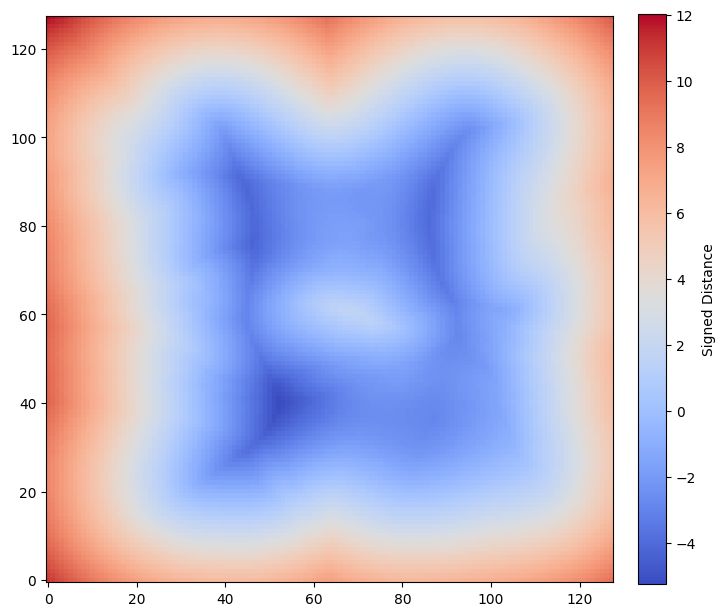

In [20]:
import matplotlib.pyplot as plt

k = 50  # middle z-slice
plt.figure(figsize=(8, 8))
plt.imshow(np.fliplr(sdf[:, :, k].T), origin="lower", cmap="coolwarm")
#plt.title(f"SDF Slice @ z={k}")
plt.colorbar(label="Signed Distance", fraction=0.046, pad=0.04)
plt.savefig("SDFk50.pdf", format="pdf", bbox_inches="tight")
plt.show()